In [1]:
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.model_selection import GridSearchCV

78876 rows of dihiggs data Index(['hh_mass', 'h1_mass', 'h2_mass', 'hh_pt', 'h1_pt', 'h2_pt',
       'deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)',
       'deltaPhi(h1, h2)', 'deltaPhi(h1 jets)', 'deltaPhi(h2 jets)', 'met',
       'met_phi', 'scalarHT', 'nJets', 'nBTags', 'jet1_pt', 'jet2_pt',
       'jet3_pt', 'jet4_pt', 'jet1_eta', 'jet2_eta', 'jet3_eta', 'jet4_eta',
       'jet1_phi', 'jet2_phi', 'jet3_phi', 'jet4_phi', 'jet1_mass',
       'jet2_mass', 'jet3_mass', 'jet4_mass', 'jet1_px', 'jet2_px', 'jet3_px',
       'jet4_px', 'jet1_py', 'jet2_py', 'jet3_py', 'jet4_py', 'jet1_pz',
       'jet2_pz', 'jet3_pz', 'jet4_pz', 'jet1_energy', 'jet2_energy',
       'jet3_energy', 'jet4_energy', 'jet1_btag', 'jet2_btag', 'jet3_btag',
       'jet4_btag', 'isSignal'],
      dtype='object')
29176 rows of qcd data Index(['hh_mass', 'h1_mass', 'h2_mass', 'hh_pt', 'h1_pt', 'h2_pt',
       'deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)',
       'deltaPhi(h1, h2)', 'deltaPhi(h1 jets)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6775733b10>]],
      dtype=object)

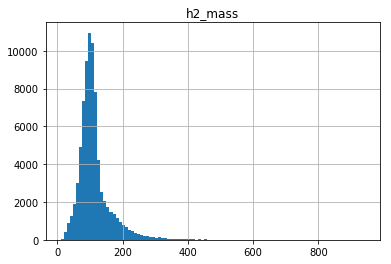

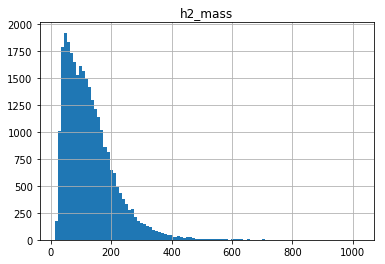

In [2]:
# *** 0. Import Dataset
qcd_raw = pd.read_csv('../samples_500k/qcd_outputDataForLearning.csv')
hh_raw = pd.read_csv('../samples_500k/dihiggs_outputDataForLearning.csv')

hh_raw.head()
hh_raw['isSignal'] = 1
hh_raw = hh_raw.drop('isMatchable', 1)
print(len(hh_raw), "rows of dihiggs data", hh_raw.columns)
#print( print(hh_raw.loc[[10]]))

qcd_raw.head()
qcd_raw['isSignal'] = 0
qcd_raw = qcd_raw.drop('isMatchable', 1)
print(len(qcd_raw), "rows of qcd data", qcd_raw.columns)

variableNames = ['hh_mass', 'h1_mass', 'h2_mass']
#variableNames = ['deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)']
#variableNames = ['hh_mass', 'h1_mass', 'h2_mass', 'deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)']

hh_raw.hist(column=variableNames[2], bins=100)
qcd_raw.hist(column=variableNames[2], bins=100)


In [3]:
def makeEqualSamplesWithUserVariables(signal_raw, bkg_raw, userVariables, nEventsForXGB):
    """function to return 4 dataframes containing user-specified variables and number of events: 1 signal for training, 1 bkg for training, 1 signal for plotting, 1 bkg for plotting"""
    
    # *** 0. Reduce dataframes to only desired variables
    signal_reduced  = signal_raw[userVariables]
    bkg_reduced     = bkg_raw[userVariables]
    signal_labels   = signal_raw[ ['isSignal'] ]
    bkg_labels      = bkg_raw[ ['isSignal'] ]

    # *** 1. Take first nEventsForXGB events for passing to XGB 
    signal_reducedForXGB  = signal_reduced[:nEventsForXGB]
    bkg_reducedForXGB     = bkg_reduced[:nEventsForXGB]
    signal_labelsForXGB   = signal_labels[:nEventsForXGB]
    bkg_labelsForXGB      = bkg_labels[:nEventsForXGB]

    # *** 2. Combine bkg+signal for passing to XGB 
    all_reducedForXGB  = signal_reducedForXGB.append(bkg_reducedForXGB)
    all_labelsForXGB   = signal_labelsForXGB.append(bkg_labelsForXGB)

    
    # ** 3. Use additional events for unambiguous testing 
    signal_reducedForPlots  = signal_reduced[nEventsForXGB:len(bkg_reduced)]
    bkg_reducedForPlots     = bkg_reduced[nEventsForXGB:len(bkg_reduced)]
    signal_labelsForPlots   = signal_labels[nEventsForXGB:len(bkg_reduced)]
    bkg_labelsForPlots      = bkg_labels[nEventsForXGB:len(bkg_reduced)]

    # *** 4. Sanity check
    print(len(all_reducedForXGB), 'rows of data with ', len(all_labelsForXGB), 'labels [XGB]')
    print(len(signal_reducedForPlots), 'rows of signal data with ', len(bkg_labelsForPlots), 'rows of background [Plots]')

    
    return all_reducedForXGB, all_labelsForXGB, signal_reducedForPlots, signal_labelsForPlots, bkg_reducedForPlots, bkg_labelsForPlots

In [38]:
def setupAndTrainBDT(all_data, all_labels, _testSize=0.3, _dumpModelInfo=False, _maxDepth=3, _eta=0.3):
    """setup and train BDT"""
    
    # *** 1. Split dataset into test + train, make correct input objects
    data_train, data_test, label_train, label_test = train_test_split(all_data, all_labels, test_size=_testSize)

    D_train = xgb.DMatrix(data_train, label=label_train)
    D_test = xgb.DMatrix(data_test, label=label_test)
    
    # *** 2. Define XGB model 
    param = {
        'eta': _eta, 
        'max_depth': _maxDepth,  
        'objective': 'multi:softprob',  
        #'objective': 'reg:logistic',  
        #'objective': 'binary:logistic',
        'num_class': 2} 

    steps = 5  # The number of training iterations

    # *** 3. Train model 
    model = xgb.train(param, D_train, steps)
    
    # *** 4. Evaluate model
    preds = model.predict(D_test)
    best_preds = np.asarray([np.argmax(line) for line in preds])

    print("Precision = {}".format(precision_score(label_test, best_preds, average='macro')))
    print("Recall = {}".format(recall_score(label_test, best_preds, average='macro')))
    print("Accuracy = {}".format(accuracy_score(label_test, best_preds)))
    
    # *** 5. Dump .txt of trees and leaves with decisions if desired
    if (_dumpModelInfo):
        model.dump_model('dumpTree.reduced_bdt.txt')

        # Make a visual of decision tree
        xgb.plot_tree(model,num_trees=1)
        #plt.rcParams['figure.figsize'] = [2000, 400]
        #plt.show()
        plt.savefig('tree0.png')
    
    
    return model

def setupGridAndTrainBDT(_modelName, all_data, all_labels, _testSize=0.3, _dumpModelInfo=False):
    """setup and train using grid of hyperparameters BDT"""
    
    # *** 1. Split dataset into test + train, make correct input objects
    data_train, data_test, label_train, label_test = train_test_split(all_data, all_labels, test_size=_testSize)

    D_train = xgb.DMatrix(data_train, label=label_train)
    D_test = xgb.DMatrix(data_test, label=label_test)
    
    # *** 2. Define XGB hyper-parameter grid 
    parameters = {
        "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
        "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
        #"min_child_weight" : [ 1, 3, 5, 7 ],
        #"gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
        #"colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
        "objective": ["multi:softprob"],
        "num_class": [2]
        }

    steps = 5  # The number of training iterations

    # *** 3. Perform grid optimization 
    clf = xgb.XGBClassifier()
    grid = GridSearchCV(clf,
                        parameters, n_jobs=4,
                        #scoring="neg_log_loss",
                        scoring="f1",
                        cv=3,
                        verbose = 3)

    grid_result = grid.fit(data_train, label_train)
    best_params = grid_result.best_params_
    print(best_params, type(best_params))
    
    # *** 4. Train model 
    model = xgb.train( best_params, D_train, steps)
    
    
    # *** 5. Evaluate model
    preds = model.predict(D_test)
    best_preds = np.asarray([np.argmax(line) for line in preds])

    print("Precision = {}".format(precision_score(label_test, best_preds, average='macro')))
    print("Recall = {}".format(recall_score(label_test, best_preds, average='macro')))
    print("Accuracy = {}".format(accuracy_score(label_test, best_preds)))
    
    # *** 5. Dump .txt of trees and leaves with decisions if desired
    if (_dumpModelInfo):
        model.dump_model('dumpTree.{0}.txt'.format(_modelName))

        # Make a visual of decision tree
        #xgb.plot_tree(model,num_trees=1)
    
    
    return model

In [42]:
def plotBDTOutputAndTree(_model, _modelName, _signalData, _signalLabels, _bkgData, _bkgLabels, _savePlots=False):
    """make plots of BDT outputs for signal+background probabilities and tree plot"""
    
    # *** 1. Make some 1D histograms of signal decision outputs
    signal_DMatrix = xgb.DMatrix(_signalData, label=_signalLabels)
    preds_signal = _model.predict(signal_DMatrix)
    sig_pred_isBkg     = [x[0] for x in preds_signal]
    sig_pred_isSignal  = [x[1] for x in preds_signal]
    #plt.hist(preds_hh)

    # *** 2. Make some 1D histograms of background decision outputs
    bkg_DMatrix = xgb.DMatrix(_bkgData, label=_bkgLabels)
    preds_bkg = _model.predict(bkg_DMatrix)
    bkg_pred_isBkg    = [x[0] for x in preds_bkg]
    bkg_pred_isSignal = [x[1] for x in preds_bkg]
    #plt.hist(preds_qcd)

    # *** 3. Plot feature importance
    if(_savePlots):
        xgb.plot_importance(_model)
        _fig = plt.gcf()
        _scope    = _modelName.split(' ')[0].lower()
        _variable = 'featureImportance'
        _filename  = _scope + '_' + _variable
        _fig.savefig( _filename+'.png', bbox_inches='tight' )
    
    # *** 4. Make dict for plotting with borrowed functions
    _nBins = 50
    predictionResults = {'hh_pred_isSignal':sig_pred_isSignal, 'hh_pred_isBkg':sig_pred_isBkg, 'qcd_pred_isSignal':bkg_pred_isSignal, 'qcd_pred_isBkg':bkg_pred_isBkg,}
    compareManyHistograms( predictionResults, ['hh_pred_isSignal', 'qcd_pred_isSignal'], 2, 'Signal Prediction', 'BDT Score ({0})'.format(_modelName), 0, 1, _nBins, _savePlot=_savePlots )
    compareManyHistograms( predictionResults, ['hh_pred_isBkg', 'qcd_pred_isBkg'], 2, 'Bkg Prediction', 'BDT Score ({0})'.format(_modelName), 0, 1, _nBins, _savePlot=_savePlots )

    # *** 5. Make plot of 0th tree
    xgb.plot_tree(_model,num_trees=0)
    plt.gcf().set_size_inches(100, 67)
    _fig = plt.gcf()
    plt.show()
    
    if(_savePlots):
        _variable = 'firstTrainedDecisionTree'
        _filename  = _scope + '_' + _variable
        _fig.savefig( _filename+'.png' )
        
    # *** 6. restore figure defaults
    plt.rcParams['figure.figsize'] = [6.4, 4.8]

    
    return



def compareManyHistograms( _dict, _labels, _nPlot, _title, _xtitle, _xMin, _xMax, _nBins, _normed=False, _savePlot=False):
       
    if len(_dict.keys()) < len(_labels):
        print ("!!! Unequal number of arrays and labels. Learn to count better.")
        return 0
    
    plt.figure(_nPlot)
    if _normed:
        plt.title(_title + ' (Normalized)')
    else:
        plt.title(_title)
    plt.xlabel(_xtitle)
    plt.ylabel('N_events')
    _bins = np.linspace(_xMin, _xMax, _nBins)
   
    y_max = 0
    for iLabel in _labels:
        plt.hist(_dict[iLabel], _bins, alpha=0.5, density=_normed, label= iLabel+' Events')
        
        # get values of histgoram to find greatest y
        #_y, _x, _ = plt.hist(_dict[iLabel])
        #if (_y.max() > y_max):
        #    y_max = _y.max()
    
    # set max y-value of histogram so there's room for legend
    axes = plt.gca()
    axes.set_ylim([0,11000])
    #plt.ylim([0,1.2*y_max])
    
    #draw legend
    plt.legend(loc='upper left')
    #plt.text(.1, .1, s1)
    
    # store figure copy for later saving
    fig = plt.gcf()
    
    # draw interactively
    plt.show()
    
    #save an image file
    if(_savePlot):
        _scope    = _title.split(' ')[0].lower()
        _variable = _xtitle.lstrip('Jet Pair').replace(' ','').replace('[GeV]','').replace('(','_').replace(')','')
        _filename  = _scope + '_' + _variable
        if _normed:
            _filename = _filename + '_norm'
        fig.savefig( _filename+'.png', bbox_inches='tight' )
    
    
    return

In [6]:
nEventsToTrain = 10000

# *** 1. Make mix of dihiggs and QCD for h1, h2, hh mass variables
variables_massesOnly = ['hh_mass', 'h1_mass', 'h2_mass']
massesOnly_data, massesOnly_labels, hh_massesOnly_data, hh_massesOnly_labels, qcd_massesOnly_data, qcd_massesOnly_labels = makeEqualSamplesWithUserVariables(hh_raw, qcd_raw, variables_massesOnly, nEventsToTrain) 
model_massesOnly = setupAndTrainBDT(massesOnly_data, massesOnly_labels)

# *** 2. Make mix of dihiggs and QCD for only anglular-basis jet info (pt, eta, phi, mass) 
jetLabels = ['1','2','3','4']
jetVariables = ['pt', 'eta', 'phi', 'mass']
variables_angularJetInfo = ['jet{0}_{1}'.format(iJetLabel, iJetVariable) for iJetLabel in jetLabels for iJetVariable in jetVariables]
angularJetInfo_data, angularJetInfo_labels, hh_angularJetInfo_data, hh_angularJetInfo_labels, qcd_angularJetInfo_data, qcd_angularJetInfo_labels = makeEqualSamplesWithUserVariables(hh_raw, qcd_raw, variables_angularJetInfo, nEventsToTrain) 
model_angularJetInfo = setupAndTrainBDT(angularJetInfo_data, angularJetInfo_labels)

# *** 3. Make mix of dihiggs and QCD for anglular+momentum basis jet info (pt, eta, phi, mass, E, px, py, pz)
jetVariables = ['pt', 'eta', 'phi', 'mass', 'px', 'py', 'pz', 'energy']
variables_allJetInfo = ['jet{0}_{1}'.format(iJetLabel, iJetVariable) for iJetLabel in jetLabels for iJetVariable in jetVariables]
allJetInfo_data, allJetInfo_labels, hh_allJetInfo_data, hh_allJetInfo_labels, qcd_allJetInfo_data, qcd_allJetInfo_labels = makeEqualSamplesWithUserVariables(hh_raw, qcd_raw, variables_allJetInfo, nEventsToTrain) 
model_allJetInfo = setupAndTrainBDT(allJetInfo_data, allJetInfo_labels)

# *** 4. Make mix of dihiggs and QCD for all variables
variables_all = list(hh_raw.columns)
variables_all.remove('isSignal') # don't want to pass answer to as part of data
all_data, all_labels, hh_all_data, hh_all_labels, qcd_all_data, qcd_all_labels = makeEqualSamplesWithUserVariables(hh_raw, qcd_raw, variables_all, nEventsToTrain) 
model_all = setupAndTrainBDT(all_data, all_labels)

# *** 5. Make mix of dihiggs and QCD for h1, h2, hh deltaR variables
variables_deltaROnly = ['deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)']
deltaROnly_data, deltaROnly_labels, hh_deltaROnly_data, hh_deltaROnly_labels, qcd_deltaROnly_data, qcd_deltaROnly_labels = makeEqualSamplesWithUserVariables(hh_raw, qcd_raw, variables_deltaROnly, nEventsToTrain) 
model_deltaROnly = setupAndTrainBDT(deltaROnly_data, deltaROnly_labels)


20000 rows of data with  20000 labels [XGB]
19176 rows of signal data with  19176 rows of background [Plots]
Precision = 0.72713741095533
Recall = 0.7253260303396668
Accuracy = 0.7246666666666667
20000 rows of data with  20000 labels [XGB]
19176 rows of signal data with  19176 rows of background [Plots]
Precision = 0.6031483695155069
Recall = 0.5981105981105981
Accuracy = 0.598
20000 rows of data with  20000 labels [XGB]
19176 rows of signal data with  19176 rows of background [Plots]
Precision = 0.6111653250584994
Recall = 0.6100715753692549
Accuracy = 0.6103333333333333
20000 rows of data with  20000 labels [XGB]
19176 rows of signal data with  19176 rows of background [Plots]
Precision = 0.745996998220888
Recall = 0.7460183198180819
Accuracy = 0.746
20000 rows of data with  20000 labels [XGB]
19176 rows of signal data with  19176 rows of background [Plots]
Precision = 0.7056681560059573
Recall = 0.7056674247410777
Accuracy = 0.7056666666666667


In [ ]:
#try grid
grid_massesOnly = setupGridAndTrainBDT('massesOnly', massesOnly_data, massesOnly_labels, _dumpModelInfo=True)
grid_angularJetInfo = setupGridAndTrainBDT('angularJetInfo', angularJetInfo_data, angularJetInfo_labels, _dumpModelInfo=True)
grid_allJetInfo = setupGridAndTrainBDT('allJetInfo', allJetInfo_data, allJetInfo_labels, _dumpModelInfo=True)
grid_deltaROnly = setupGridAndTrainBDT('deltaROnly', deltaROnly_data, deltaROnly_labels, _dumpModelInfo=True)

In [7]:
grid_all = setupGridAndTrainBDT('allVariables', all_data, all_labels, _dumpModelInfo=True)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed: 14.0min
[Parallel(n_jobs=4)]: Done 144 out of 144 | elapsed: 16.9min finished
/home/btannenw/.local/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/btannenw/.local/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'eta': 0.05, 'max_depth': 5, 'num_class': 2, 'objective': 'multi:softprob'} <class 'dict'>
Precision = 0.754581389804901
Recall = 0.7530551401220988
Accuracy = 0.7536666666666667


In [10]:
plotBDTOutputAndTree(grid_massesOnly, 'Masses Only', hh_massesOnly_data, hh_massesOnly_labels, qcd_massesOnly_data, qcd_massesOnly_labels, _savePlots=True)
plotBDTOutputAndTree(grid_angularJetInfo, 'Position Jet Info', hh_angularJetInfo_data, hh_angularJetInfo_labels, qcd_angularJetInfo_data, qcd_angularJetInfo_labels, _savePlots=True)
plotBDTOutputAndTree(grid_allJetInfo, 'All Jet Info', hh_allJetInfo_data, hh_allJetInfo_labels, qcd_allJetInfo_data, qcd_allJetInfo_labels, _savePlots=True)
plotBDTOutputAndTree(grid_deltaROnly, 'Delta R Only', hh_deltaROnly_data, hh_deltaROnly_labels, qcd_deltaROnly_data, qcd_deltaROnly_labels, _savePlots=True)
plotBDTOutputAndTree(grid_all, 'All Variables', hh_all_data, hh_all_labels, qcd_all_data, qcd_all_labels, _savePlots=True)
#plotBDTOutputAndTree(model_all, 'All Variables', hh_all_data, hh_all_labels, qcd_all_data, qcd_all_labels, _savePlots=True)


NameError: name 'grid_massesOnly' is not defined

In [ ]:
## TO-DO
[X] Grid optimization
[X] Train with all variables
3) isolate most important values 
[X] understand meaning of F score
[X] slides
6) some significance values for comparing with rectangular

20000 rows of data with  20000 labels [XGB]
19176 rows of signal data with  19176 rows of background [Plots]
Precision = 0.7683383152441137
Recall = 0.7683266275560834
Accuracy = 0.7683333333333333


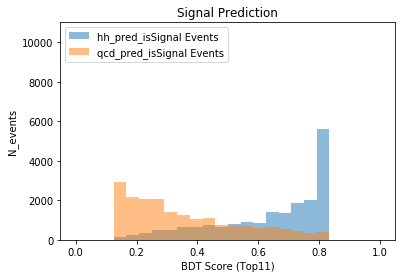

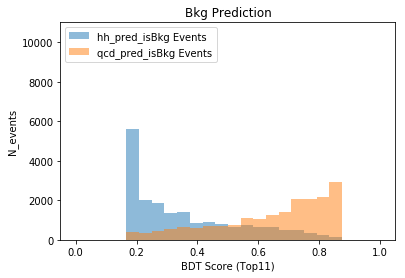

ValueError: Unable to parse node: 3:[deltaR(h1,

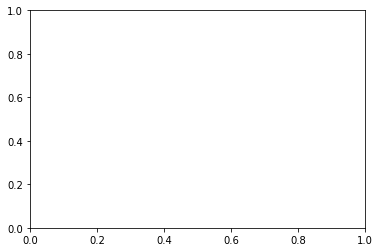

In [30]:
# *** 5. Make mix of dihiggs and QCD for top-11 optimal variables
variables_top11 = ['deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)', 'hh_mass', 'h1_mass', 'h2_mass','hh_pt', 'h1_pt', 'h2_pt', 'scalarHT', 'jet4_pt']
top11_data, top11_labels, hh_top11_data, hh_top11_labels, qcd_top11_data, qcd_top11_labels = makeEqualSamplesWithUserVariables(hh_raw, qcd_raw, variables_top11, nEventsToTrain) 
model_top11 = setupAndTrainBDT(top11_data, top11_labels, _maxDepth=5, _eta=0.3)
plotBDTOutputAndTree(model_top11, 'Top11', hh_top11_data, hh_top11_labels, qcd_top11_data, qcd_top11_labels, _savePlots=False)


20000 rows of data with  20000 labels [XGB]
19176 rows of signal data with  19176 rows of background [Plots]
Precision = 0.774451684941334
Recall = 0.7743079934546311
Accuracy = 0.7743333333333333


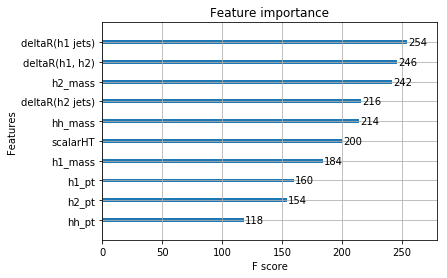

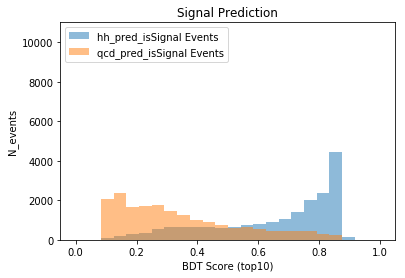

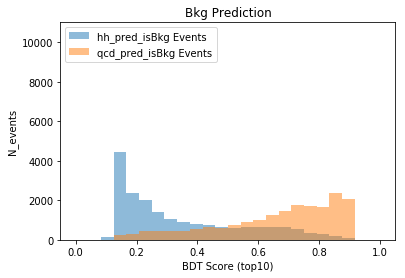

ValueError: Unable to parse node: 3:[deltaR(h1,

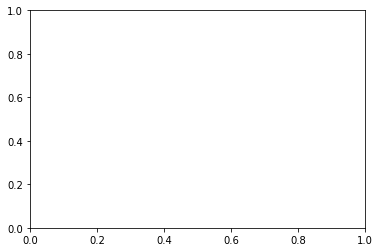

In [37]:
# *** 5. Make mix of dihiggs and QCD for top-10 optimal variables
variables_top10 = ['deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)', 'hh_mass', 'h1_mass', 'h2_mass','hh_pt', 'h1_pt', 'h2_pt', 'scalarHT']
top10_data, top10_labels, hh_top10_data, hh_top10_labels, qcd_top10_data, qcd_top10_labels = makeEqualSamplesWithUserVariables(hh_raw, qcd_raw, variables_top10, nEventsToTrain) 
model_top10 = setupAndTrainBDT(top10_data, top10_labels, _maxDepth=8, _eta=0.3)
plotBDTOutputAndTree(model_top10, 'top10', hh_top10_data, hh_top10_labels, qcd_top10_data, qcd_top10_labels, _savePlots=True)


20000 rows of data with  20000 labels [XGB]
19176 rows of signal data with  19176 rows of background [Plots]
Precision = 0.7640502812695327
Recall = 0.7640474645676396
Accuracy = 0.764


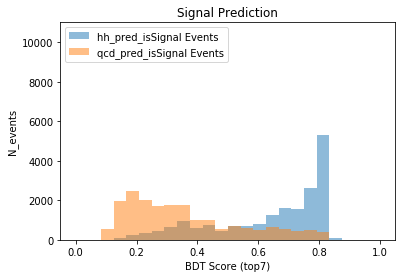

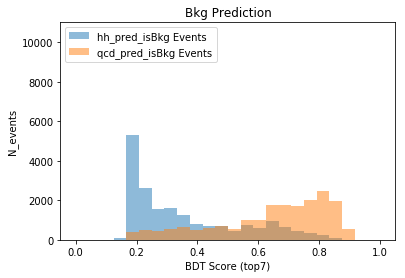

ValueError: Unable to parse node: 3:[deltaR(h1,

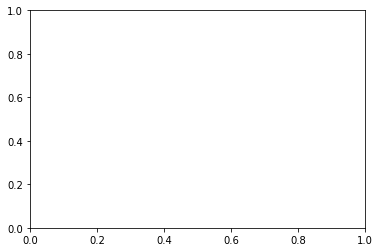

In [32]:
# *** 5. Make mix of dihiggs and QCD for top-7 optimal variables
variables_top7 = ['deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)', 'hh_mass', 'h1_mass', 'h2_mass', 'scalarHT']
top7_data, top7_labels, hh_top7_data, hh_top7_labels, qcd_top7_data, qcd_top7_labels = makeEqualSamplesWithUserVariables(hh_raw, qcd_raw, variables_top7, nEventsToTrain) 
model_top7 = setupAndTrainBDT(top7_data, top7_labels, _maxDepth=5, _eta=0.3)
plotBDTOutputAndTree(model_top7, 'top7', hh_top7_data, hh_top7_labels, qcd_top7_data, qcd_top7_labels, _savePlots=False)


20000 rows of data with  20000 labels [XGB]
19176 rows of signal data with  19176 rows of background [Plots]
Precision = 0.7580392101030955
Recall = 0.7578410669630453
Accuracy = 0.7575


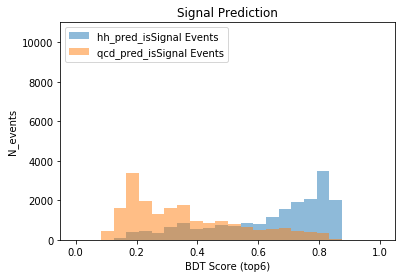

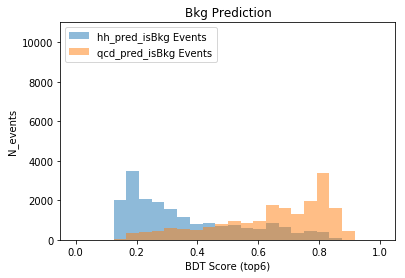

ValueError: Unable to parse node: 3:[deltaR(h1,

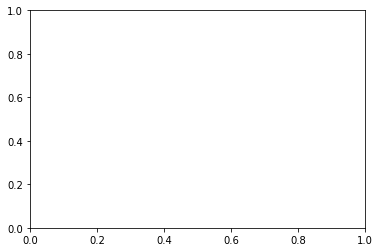

In [29]:
# *** 5. Make mix of dihiggs and QCD for top-6 optimal variables
variables_top6 = ['deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)', 'h1_mass', 'h2_mass', 'scalarHT']
top6_data, top6_labels, hh_top6_data, hh_top6_labels, qcd_top6_data, qcd_top6_labels = makeEqualSamplesWithUserVariables(hh_raw, qcd_raw, variables_top6, nEventsToTrain) 
model_top6 = setupAndTrainBDT(top6_data, top6_labels, _maxDepth=5, _eta=0.3)
plotBDTOutputAndTree(model_top6, 'top6', hh_top6_data, hh_top6_labels, qcd_top6_data, qcd_top6_labels, _savePlots=False)


In [39]:
grid_all = setupGridAndTrainBDT('top10', top10_data, top10_labels, _dumpModelInfo=True)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   44.7s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 144 out of 144 | elapsed:  4.5min finished
/home/btannenw/.local/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/btannenw/.local/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'eta': 0.05, 'max_depth': 5, 'num_class': 2, 'objective': 'multi:softprob'} <class 'dict'>
Precision = 0.7583998051696197
Recall = 0.7578795443907005
Accuracy = 0.7575


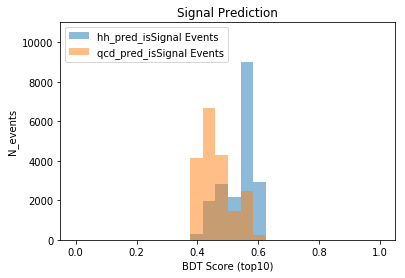

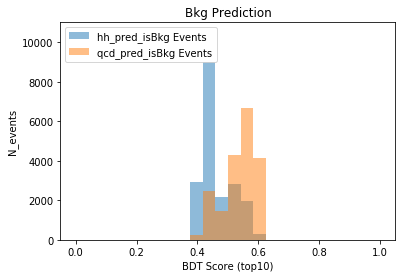

ValueError: Unable to parse node: 3:[deltaR(h1,

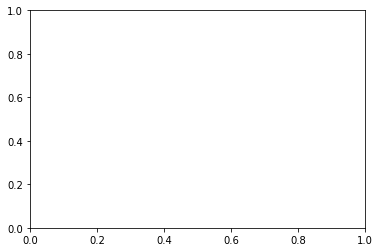

In [41]:
plotBDTOutputAndTree(grid_all, 'top10', hh_top10_data, hh_top10_labels, qcd_top10_data, qcd_top10_labels, _savePlots=False)


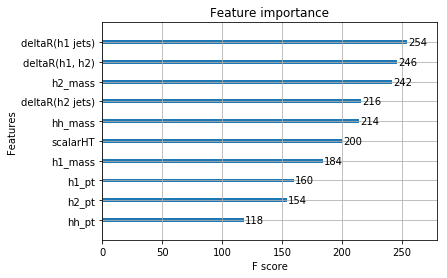

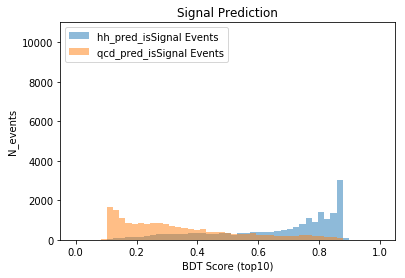

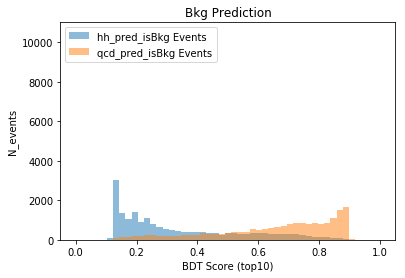

ValueError: Unable to parse node: 3:[deltaR(h1,

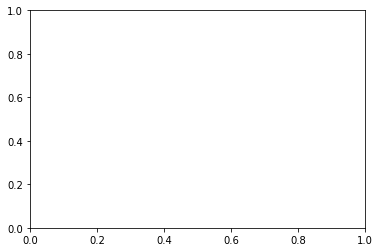

In [43]:
plotBDTOutputAndTree(model_top10, 'top10', hh_top10_data, hh_top10_labels, qcd_top10_data, qcd_top10_labels, _savePlots=True)


Precision = 0.7726711514153803
Recall = 0.7726804831640606
Accuracy = 0.7726666666666666


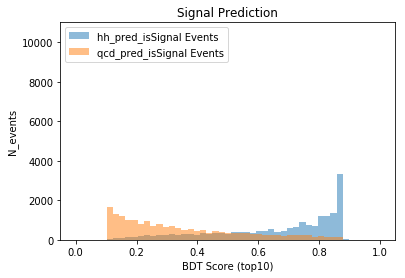

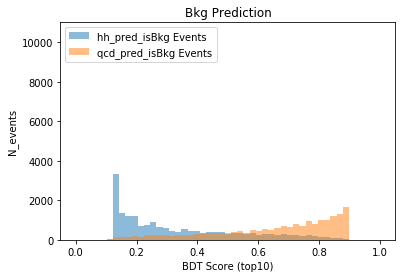

ValueError: Unable to parse node: 3:[deltaR(h1,

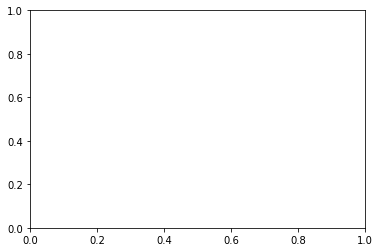

In [55]:
model_top10_2 = setupAndTrainBDT(top10_data, top10_labels, _maxDepth=8, _eta=0.3)
plotBDTOutputAndTree(model_top10_2, 'top10', hh_top10_data, hh_top10_labels, qcd_top10_data, qcd_top10_labels, _savePlots=False)
